# First NN with torch 

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [3]:
file_path = "data/voice.csv"  
data = pd.read_csv(file_path)

data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values  
y = data['label'].values  

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [5]:
class SexPredictionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_dataset = SexPredictionDataset(X_train, y_train)
test_dataset = SexPredictionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.fc(x)

In [8]:
input_size = X_train.shape[1]
model = SimpleNN(input_size)


criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 10/200, Train Loss: 0.5544, F1-Score: 0.6401
Epoch 20/200, Train Loss: 0.4975, F1-Score: 0.7724
Epoch 30/200, Train Loss: 0.4539, F1-Score: 0.7952
Epoch 40/200, Train Loss: 0.4253, F1-Score: 0.8539
Epoch 50/200, Train Loss: 0.3894, F1-Score: 0.8803
Epoch 60/200, Train Loss: 0.3673, F1-Score: 0.8933
Epoch 70/200, Train Loss: 0.3171, F1-Score: 0.9101
Epoch 80/200, Train Loss: 0.2863, F1-Score: 0.9284
Epoch 90/200, Train Loss: 0.2471, F1-Score: 0.9410
Epoch 100/200, Train Loss: 0.2148, F1-Score: 0.9469
Epoch 110/200, Train Loss: 0.2015, F1-Score: 0.9453
Epoch 120/200, Train Loss: 0.1756, F1-Score: 0.9595
Epoch 130/200, Train Loss: 0.1650, F1-Score: 0.9602
Epoch 140/200, Train Loss: 0.1549, F1-Score: 0.9663
Epoch 150/200, Train Loss: 0.1532, F1-Score: 0.9598
Epoch 160/200, Train Loss: 0.1367, F1-Score: 0.9659
Epoch 170/200, Train Loss: 0.1334, F1-Score: 0.9691
Epoch 180/200, Train Loss: 0.1281, F1-Score: 0.9658
Epoch 190/200, Train Loss: 0.1284, F1-Score: 0.9655
Epoch 200/200, Train 

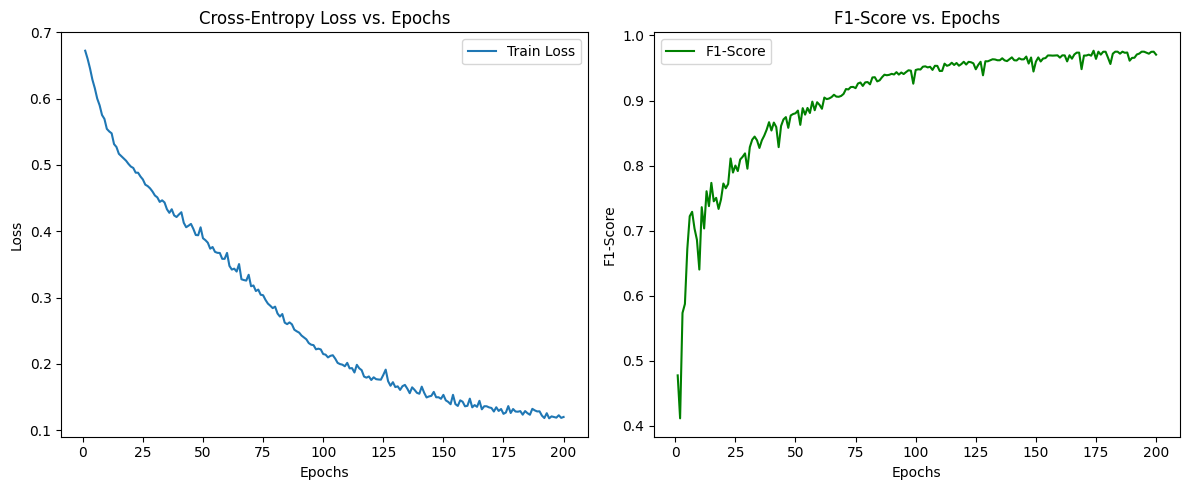

In [9]:
train_losses = []
f1_scores = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_class = (y_test_pred >= 0.5).float()
        
        f1 = f1_score(y_test.numpy(), y_test_pred_class.numpy())
        f1_scores.append(f1)

        # Afficher les résultats tous les 10 epochs
        if (epoch + 1) % 10 == 0:  # Affichage tous les 10 epochs
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, F1-Score: {f1:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), f1_scores, label='F1-Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
model.eval()  
with torch.no_grad():
    y_test_pred = model(X_test)  
    y_test_pred_class = (y_test_pred >= 0.5).float()  

    f1 = f1_score(y_test.numpy(), y_test_pred_class.numpy())
    total_correct = (y_test_pred_class == y_test).sum().item()
    accuracy = total_correct / len(y_test)

    print("\nPerformance sur le jeu de test :")
    print(f"F1-Score : {f1:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Correct Predictions : {total_correct}/{len(y_test)}")



Performance sur le jeu de test :
F1-Score : 0.9705
Accuracy : 0.9685
Correct Predictions : 614/634


# Second modèle avec batchnormalization

In [11]:
class SimpleNNWithBatchNorm(nn.Module):
    def __init__(self, input_size):
        super(SimpleNNWithBatchNorm, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 16),      
            nn.BatchNorm1d(16),            
            nn.ReLU(),                    
            nn.Linear(16, 8),              
            nn.BatchNorm1d(8),             
            nn.ReLU(),                     
            nn.Linear(8, 1),               
            nn.Sigmoid()                   
        )

    def forward(self, x):
        return self.fc(x)

Epoch 10/200, Train Loss: 0.2522, F1-Score: 0.9594
Epoch 20/200, Train Loss: 0.1558, F1-Score: 0.9717
Epoch 30/200, Train Loss: 0.1465, F1-Score: 0.9692
Epoch 40/200, Train Loss: 0.1677, F1-Score: 0.9532
Epoch 50/200, Train Loss: 0.1422, F1-Score: 0.9681
Epoch 60/200, Train Loss: 0.1267, F1-Score: 0.9776
Epoch 70/200, Train Loss: 0.1548, F1-Score: 0.9652
Epoch 80/200, Train Loss: 0.1308, F1-Score: 0.9694
Epoch 90/200, Train Loss: 0.1367, F1-Score: 0.9752
Epoch 100/200, Train Loss: 0.1183, F1-Score: 0.9613
Epoch 110/200, Train Loss: 0.1259, F1-Score: 0.9712
Epoch 120/200, Train Loss: 0.1109, F1-Score: 0.9763
Epoch 130/200, Train Loss: 0.1106, F1-Score: 0.9598
Epoch 140/200, Train Loss: 0.1280, F1-Score: 0.9722
Epoch 150/200, Train Loss: 0.1372, F1-Score: 0.9617
Epoch 160/200, Train Loss: 0.0969, F1-Score: 0.9680
Epoch 170/200, Train Loss: 0.2090, F1-Score: 0.9678
Epoch 180/200, Train Loss: 0.1692, F1-Score: 0.9694
Epoch 190/200, Train Loss: 0.1166, F1-Score: 0.9780
Epoch 200/200, Train 

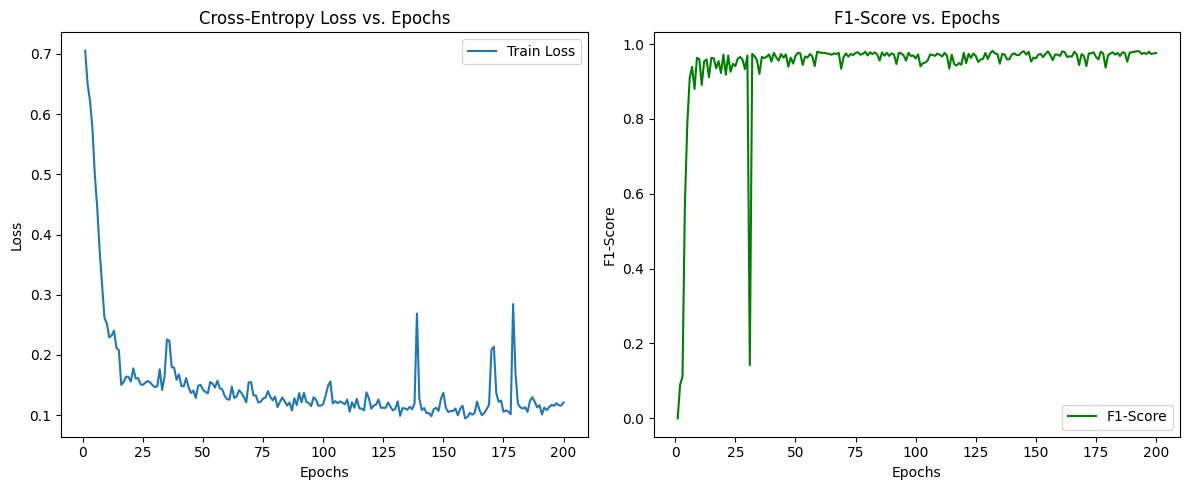

In [12]:
input_size = X_train.shape[1]
model = SimpleNNWithBatchNorm(input_size)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
f1_scores = []

epochs = 200
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred_class = (y_test_pred >= 0.5).float()
        f1 = f1_score(y_test.numpy(), y_test_pred_class.numpy())
        f1_scores.append(f1)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, F1-Score: {f1:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross-Entropy Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), f1_scores, label='F1-Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
model.eval()  
with torch.no_grad():
    y_test_pred = model(X_test)  
    y_test_pred_class = (y_test_pred >= 0.5).float()  

    f1 = f1_score(y_test.numpy(), y_test_pred_class.numpy())
    total_correct = (y_test_pred_class == y_test).sum().item()
    accuracy = total_correct / len(y_test)

    print("\nPerformance sur le jeu de test :")
    print(f"F1-Score : {f1:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Correct Predictions : {total_correct}/{len(y_test)}")



Performance sur le jeu de test :
F1-Score : 0.9761
Accuracy : 0.9748
Correct Predictions : 618/634
